# Решение тестового задания Стажировки в ВК

### Импорт библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_117747/3698959207.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Загрузка данных

In [2]:
train_data = pd.read_csv("data/trainee_train.csv")

In [3]:
train_data

,Unnamed: 0,im,v1,v2,v3,v4,v5,v6,v7,v8,...,v437,v438,v439,v440,v441,v442,v443,v444,v445,v446
0,0,0.0,128.100243,128.157072,129.255102,128.273006,126.532819,129.023232,129.854839,129.828431,...,128.800985,128.232694,128.211893,130.512476,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
1,1,1.0,128.100243,128.157072,126.636364,128.273006,130.810403,129.023232,128.633333,128.994152,...,128.914365,128.232694,128.211893,128.167519,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
2,2,1.0,128.100243,128.157072,129.255102,128.273006,130.810403,129.023232,126.769231,126.926295,...,128.800985,128.232694,128.211893,128.167519,128.051724,127.709786,127.349282,127.063052,125.169118,125.274194
3,3,1.0,128.100243,128.157072,127.630027,128.273006,126.532819,129.023232,126.769231,126.926295,...,128.800985,130.794007,131.026119,130.512476,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
4,4,1.0,128.100243,128.336364,129.255102,128.273006,130.810403,126.042980,129.854839,126.926295,...,128.800985,130.794007,131.026119,130.512476,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,611,0.0,128.100243,128.157072,129.255102,128.273006,130.810403,129.023232,129.854839,129.828431,...,128.800985,128.232694,128.211893,126.744108,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
612,612,1.0,128.100243,128.157072,129.255102,128.273006,126.532819,129.023232,126.769231,126.926295,...,128.800985,128.232694,128.211893,126.744108,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
613,613,1.0,130.798507,131.174905,129.255102,117.900000,132.860465,130.381148,129.854839,129.828431,...,128.914365,128.232694,128.211893,128.167519,128.051724,127.709786,127.349282,127.063052,125.169118,126.611554
614,614,1.0,128.100243,128.157072,129.255102,128.273006,126.532819,129.023232,129.854839,126.926295,...,128.800985,128.232694,128.211893,128.167519,128.051724,127.709786,127.349282,127.063052,130.477398,130.496150


<BarContainer object of 2 artists>

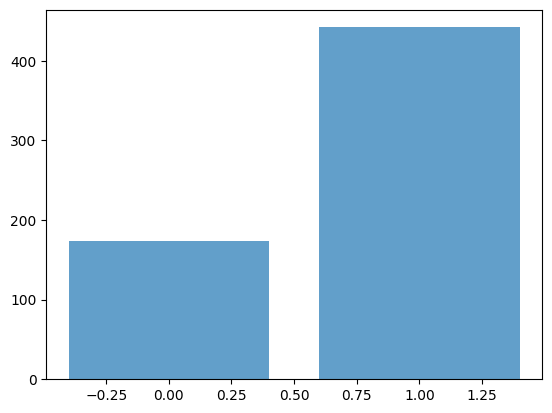

In [4]:
unique_classes, class_counts = np.unique(train_data['im'], return_counts=True)
plt.bar(unique_classes, class_counts, align='center', alpha=0.7)

In [5]:
X = train_data.drop('im', axis=1)
y = train_data['im']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Логистическая регрессия

In [8]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), #normalize data
    ('model', LogisticRegression(penalty="l2")) #classifier
])

p = {
    "model__C": [0.0464] #np.logspace(-4,4,10)
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=p,
    scoring="roc_auc",
    n_jobs=-1,
    cv=10,
)
logreg = grid_search.fit(X, y)

In [9]:
print(f"best score: {logreg.best_score_}")
print(f"best params: {logreg.best_params_}")

best score: 0.9272162804515747
best params: {'model__C': 0.0464}


### Cлучайный лес

In [10]:
classifier = RandomForestClassifier(n_estimators=200, random_state=42)


PARAMS = {
    "min_samples_split": [5], #range(5, 200, 10),
    "min_samples_leaf": [1] #range(1, 100, 10),
}


grid_search = GridSearchCV(classifier, PARAMS, scoring="roc_auc", cv=5)
rf = grid_search.fit(X, y);

In [11]:
print(f"Best score: {rf.best_score_}")
print(f"Best params: {rf.best_params_}")

Best score: 0.9243824516527755
Best params: {'min_samples_leaf': 1, 'min_samples_split': 5}


### Метод ближайших соседей

In [12]:
PARAMS = {
    "model__n_neighbors": [11] # range(1, 100, 5),
}

clf = Pipeline(steps=[
    ('scaler', StandardScaler()), #normalize data
    ('model', KNeighborsClassifier()) #classifier
])
    
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=PARAMS,
    scoring="roc_auc",
    n_jobs=-1,
    cv=10
)
knn = grid_search.fit(X, y)

In [13]:
print(f"Best score: {knn.best_score_}")
print(f"Best params: {knn.best_params_}")

Best score: 0.9154062685680333
Best params: {'model__n_neighbors': 11}


### CatBoost

In [56]:
param_grid = {
    'l2_leaf_reg': [3], # [3, 5, 7, 10],
    'depth': [5], #[4, 6, 8],
    'learning_rate': [0.05], #[0.01, 0.05, 0.1],
    'iterations': [700], #[100, 200, 300, 500]
}


# Создание модели CatBoost
base_model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_seed=42)

# Использование GridSearchCV для поиска по сетке
catboost = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='roc_auc', cv=3)


In [57]:
catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50)

0:	test: 0.8327300	best: 0.8327300 (0)	total: 2.06ms	remaining: 1.44s
50:	test: 0.8944193	best: 0.8944193 (50)	total: 122ms	remaining: 1.55s
100:	test: 0.9152338	best: 0.9161388 (96)	total: 212ms	remaining: 1.26s
150:	test: 0.9254902	best: 0.9254902 (149)	total: 308ms	remaining: 1.12s
200:	test: 0.9273002	best: 0.9273002 (200)	total: 397ms	remaining: 986ms
250:	test: 0.9266968	best: 0.9273002 (200)	total: 490ms	remaining: 877ms
300:	test: 0.9279035	best: 0.9291101 (292)	total: 576ms	remaining: 764ms
350:	test: 0.9297134	best: 0.9303167 (341)	total: 662ms	remaining: 658ms
400:	test: 0.9294118	best: 0.9312217 (364)	total: 759ms	remaining: 566ms
450:	test: 0.9288084	best: 0.9312217 (364)	total: 851ms	remaining: 470ms
500:	test: 0.9276018	best: 0.9312217 (364)	total: 938ms	remaining: 373ms
550:	test: 0.9282051	best: 0.9312217 (364)	total: 1.03s	remaining: 279ms
600:	test: 0.9269985	best: 0.9312217 (364)	total: 1.12s	remaining: 185ms
650:	test: 0.9269985	best: 0.9312217 (364)	total: 1.23s	r

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd9fa475850>,
             param_grid={'depth': [5], 'iterations': [700], 'l2_leaf_reg': [3],
                         'learning_rate': [0.05]},
             scoring='roc_auc')

In [58]:
best_params = catboost.best_params_
print(f"Best score: {catboost.best_score_}")
print(f'Best Parameters: {best_params}')

Best score: 0.9211951447245564
Best Parameters: {'depth': 5, 'iterations': 700, 'l2_leaf_reg': 3, 'learning_rate': 0.05}


In [59]:
y_pred = catboost.predict_proba(X_test)[:, 1]

# Вычисление ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc}')

ROC-AUC: 0.9508295625942684


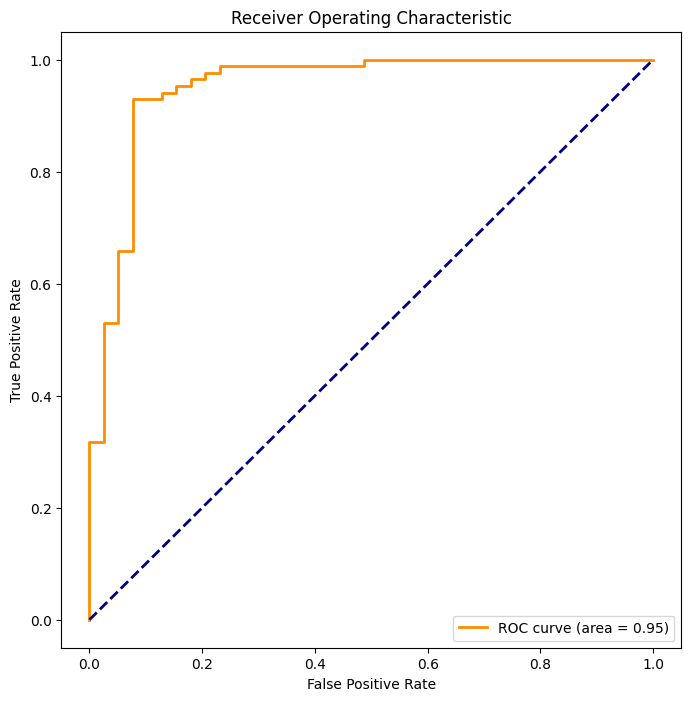

In [60]:
# Визуализация ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Stacking

In [23]:
final = CatBoostClassifier(
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    random_seed=0,
    grow_policy="Depthwise",
    l2_leaf_reg=1,
    learning_rate=0.05,
    max_depth=15,
    min_data_in_leaf=10,
    n_estimators=20,
    random_strength=11,
    subsample=0.1,
)

stacking = StackingClassifier(
    estimators=[
        ("logreg", logreg),
        ("rf", rf),
        ("catboost", catboost),
        ("knn", knn)
    ],
    final_estimator=final,
    n_jobs=-1,
)

stacking.fit(X_train, y_train)

0:	total: 54.4ms	remaining: 27.1s
1:	total: 57.4ms	remaining: 14.3s
2:	total: 60.2ms	remaining: 9.97s
3:	total: 63ms	remaining: 7.81s
4:	total: 66ms	remaining: 6.54s
5:	total: 68.9ms	remaining: 5.67s
6:	total: 71.8ms	remaining: 5.06s
7:	total: 74.7ms	remaining: 4.59s
8:	total: 77.4ms	remaining: 4.22s
9:	total: 80.3ms	remaining: 3.94s
10:	total: 82.3ms	remaining: 3.66s
11:	total: 84ms	remaining: 3.42s
12:	total: 85.9ms	remaining: 3.22s
13:	total: 87.8ms	remaining: 3.05s
14:	total: 89.7ms	remaining: 2.9s
15:	total: 91.6ms	remaining: 2.77s
16:	total: 94.1ms	remaining: 2.67s
17:	total: 95.9ms	remaining: 2.57s
18:	total: 97.9ms	remaining: 2.48s
19:	total: 99.9ms	remaining: 2.4s
20:	total: 102ms	remaining: 2.32s
21:	total: 104ms	remaining: 2.25s
22:	total: 105ms	remaining: 2.19s
23:	total: 107ms	remaining: 2.13s
24:	total: 109ms	remaining: 2.08s
25:	total: 111ms	remaining: 2.03s
26:	total: 113ms	remaining: 1.98s
27:	total: 115ms	remaining: 1.94s
28:	total: 117ms	remaining: 1.89s
29:	total: 1

/home/constantfear/Projects/venvs/.main-venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/constantfear/Projects/venvs/.main-venv/lib/python3.11/site-packages/catboost/core.py", line 184, in log_fixup
    yield
  File "/home/constantfear/Projects/venvs/.main-venv/lib/python3.11/site-packages/catboost/core.py", line 2433, in _fit
    self.get_feature_importance(type=EFstrType.PredictionValuesChange)
  File "/home/constantfear/Projects/venvs/.main-venv/lib/python3.11/site-packages/catboost/core.py", line 3179, in get_feature_

453:	total: 2.8s	remaining: 284ms
11:	total: 81.4ms	remaining: 3.31s
6:	total: 58.8ms	remaining: 4.14s
12:	total: 84.1ms	remaining: 3.15s
493:	total: 2.93s	remaining: 35.6ms
454:	total: 2.81s	remaining: 277ms
494:	total: 2.94s	remaining: 29.7ms
455:	total: 2.81s	remaining: 271ms
495:	total: 2.94s	remaining: 23.7ms
427:	total: 2.72s	remaining: 458ms
7:	total: 69.1ms	remaining: 4.25s
13:	total: 95.7ms	remaining: 3.32s
496:	total: 2.94s	remaining: 17.8ms
456:	total: 2.81s	remaining: 265ms
428:	total: 2.73s	remaining: 451ms
14:	total: 101ms	remaining: 3.28s
8:	total: 79.1ms	remaining: 4.32s
15:	total: 104ms	remaining: 3.15s
497:	total: 2.95s	remaining: 11.9ms
429:	total: 2.73s	remaining: 445ms
498:	total: 2.96s	remaining: 5.92ms
457:	total: 2.83s	remaining: 259ms
16:	total: 111ms	remaining: 3.15s
9:	total: 87.6ms	remaining: 4.29s
17:	total: 115ms	remaining: 3.09s
499:	total: 2.96s	remaining: 0us
18:	total: 120ms	remaining: 3.03s
430:	total: 2.75s	remaining: 440ms
10:	total: 98.7ms	remainin

RuntimeError: Attempt to pop from an empty stack

In [19]:
y_pred = stacking.predict_proba(X_test)[:, 1]

# Вычисление ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc}')

ROC-AUC: 0.9159879336349924


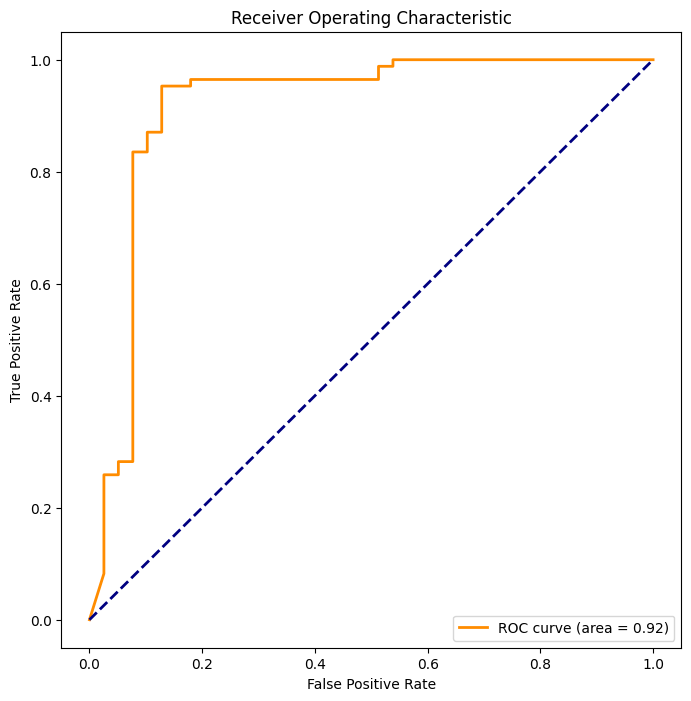

In [20]:
# Визуализация ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_data = pd.read_csv("data/trainee_test_fish.csv")

In [ ]:
submission = pd.DataFrame()
submission["im"] = stacking.predict_proba(test_data)[:, 1]
submission.to_csv("Submission/stacking.csv", index=True)

### Final

In [61]:
catboost.fit(X, y, verbose=50)


0:	total: 2.92ms	remaining: 2.04s
50:	total: 90.6ms	remaining: 1.15s
100:	total: 175ms	remaining: 1.03s
150:	total: 261ms	remaining: 951ms
200:	total: 345ms	remaining: 857ms
250:	total: 429ms	remaining: 767ms
300:	total: 514ms	remaining: 682ms
350:	total: 597ms	remaining: 594ms
400:	total: 680ms	remaining: 507ms
450:	total: 767ms	remaining: 424ms
500:	total: 851ms	remaining: 338ms
550:	total: 934ms	remaining: 253ms
600:	total: 1.02s	remaining: 168ms
650:	total: 1.1s	remaining: 83.2ms
699:	total: 1.19s	remaining: 0us
0:	total: 2.03ms	remaining: 1.42s
50:	total: 87.5ms	remaining: 1.11s
100:	total: 170ms	remaining: 1.01s
150:	total: 257ms	remaining: 935ms
200:	total: 342ms	remaining: 848ms
250:	total: 427ms	remaining: 764ms
300:	total: 517ms	remaining: 686ms
350:	total: 610ms	remaining: 606ms
400:	total: 701ms	remaining: 523ms
450:	total: 791ms	remaining: 437ms
500:	total: 877ms	remaining: 348ms
550:	total: 963ms	remaining: 260ms
600:	total: 1.05s	remaining: 173ms
650:	total: 1.14s	remain

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd9fa475850>,
             param_grid={'depth': [5], 'iterations': [700], 'l2_leaf_reg': [3],
                         'learning_rate': [0.05]},
             scoring='roc_auc')

In [ ]:
submission = pd.DataFrame()
submission["im"] = catboost.predict_proba(test_data)[:, 1]
submission.to_csv("Submission/catboost.csv", index=True)